# Executable code


Let's conduct a research on the impact of the solar activity upon the changes of the Earth temperature - the main aim is to compare the optained average temperatures for periods with high and low levels of solar activity and to found possible correlation between them.

We'll assume that there are 52 weeks in the year and calculate daily and weekly average temperature between 1818 and 2018 years in three european cities, similar to the Le Mouël's article entitled as "A solar pattern in the longest temperature series from three stations in Europe".

In [1]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex',preamble='\\usepackage[utf8]{inputenc}')
rc('text.latex',preamble='\\usepackage[russian]{babel}')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fftpack
import random
import datetime
from sortedcontainers import SortedSet
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')

MONTHS_NUMBER, DAYS_NUMBER = 12, 365
BEGIN, END = 1818, 2018
TEST_NUMBER = 100
PERIOD = 11 # один солнечный цикл

months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

DPI = 80
SIZE_X, SIZE_Y = 15, 5

Additional functions for working with dates and files are to be found here.

In [2]:
def GetDayNumber(date):
    day_number = date.day - 1
    for i in range(date.month - 1):
        day_number += months[i]
    return day_number

def GetDate(day):
    month = 0
    while month < len(months) and day >= months[month]:
        day -= months[month]
        month += 1
    return (month + 1, day + 1)

def GetDateNumber(date):
    return (date.year - BEGIN) * DAYS_NUMBER + date.day

In [3]:
suffix_letter = {"min": "TN", "avg": "TG", "max": "TX", "all": "TA"}
func_name = {np.mean: "avg", np.nanmean: "avg",
            np.median: "median", np.nanmedian: "median"}
func_name_r = {np.nanmean: "Средняя", np.nanmedian: "Медианная"}
full_case = {"min": "minimum", "avg": "average", "max": "maximum"}
full_case_r = {"min": "минимальных", "avg": "средних", "max": "максимальных"}

def GetFileName(city, case):
    return "{}_{}_formatted.txt".format(suffix_letter[case], city)

def GetTemperatureFileText(city, case):
    dtype = np.dtype([("date", np.unicode_, 8), ("temp", np.int32)])
    file_name = GetFileName(city, case)
    text = np.loadtxt(file_name, dtype=dtype, usecols=(2,3), delimiter=',')
    return text

def GetSolarFileText():
    dtype = np.dtype([("year", np.int32), ("month", np.int32), ("day", np.int32), ("spots", np.int32)])
    file_name = "solar_data_formatted.txt"
    text = np.loadtxt(file_name, dtype=dtype, usecols=(0, 1, 2, 3), delimiter=' ')
    return text

def GetMean(first, second, MyMean):
    return [(MyMean(first[i]) - MyMean(second[i])) for i in range(len(first))]

def GetPicName(city, case, suf):
    return "pic/{}_{}_{}.pdf".format(city, suffix_letter[case], suf)

As a start let's constract a line graph shows average daily solar activity throughout a 4-year period.

In [4]:
data = GetSolarFileText()

years, dates = [], []
day_spots, first_date, year_spots = dict(), dict(), dict()

start = 0
while datetime.date(data[start]["year"], data[start]["month"], data[start]["day"]) < datetime.date(1820, 1, 1):
    start += 1

finish = len(data) - 1
while datetime.date(data[finish]["year"], data[finish]["month"], data[finish]["day"]) > datetime.date(2017, 12, 31):
    finish -= 1

for i in range(start, finish):
    cur_date = datetime.date(data[i]["year"], data[i]["month"], data[i]["day"])
    cur_start = datetime.date(data[i]["year"] - 2, data[i]["month"], data[i]["day"])
    cur_finish = datetime.date(data[i]["year"] + 2, data[i]["month"], data[i]["day"])
    queue_spots = [data[i]["spots"]]

    j = i - 1
    while j >= 0 and datetime.date(data[j]["year"], data[j]["month"], data[j]["day"]) >= cur_start:
        queue_spots.append(data[j]["spots"])
        j -= 1
        
    j = i + 1
    while j < len(data) and datetime.date(data[j]["year"], data[j]["month"], data[j]["day"]) < cur_finish:
        queue_spots.append(data[j]["spots"])
        j += 1
    
    day_spots[cur_date] = np.mean(np.array(queue_spots))
    if cur_date.year not in first_date:
        first_date[cur_date.year] = cur_date
        year_spots[cur_date.year] = day_spots[cur_date]
        if (cur_date.year - BEGIN) % 20 == 0:
            years.append(cur_date.year)
            dates.append(cur_date)
    else:
        year_spots[cur_date.year] += day_spots[cur_date]

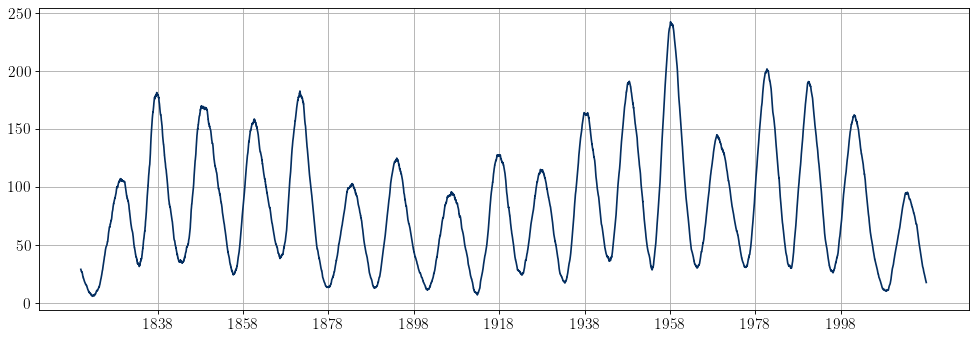

In [5]:
fig = plt.figure(dpi=DPI, figsize=(SIZE_X, SIZE_Y))
#plt.title("Сглаженное по 4 годам ежедневное ISSN")

keys = sorted(day_spots.keys())
spots = [day_spots[elem] for elem in keys]

register_matplotlib_converters()
plt.xticks(dates, years, fontsize=14)
plt.yticks(fontsize=14)
plt.plot(keys, 
         np.array(spots), 
         color="xkcd:marine")
plt.grid(True)

fig.savefig("pic/cycles.pdf", bbox_inches='tight', pad_inches=0.05)
plt.show()

Let's find the days with the lowest solar activity in keeping with the years with the minimum amount of sun spots.

In [6]:
year = 1822
years_of_minimum = [year]    

while year + 1 < END:
    while year + 1 < END and year_spots[year] <= year_spots[year + 1]:
        year += 1
    while year + 1 < END and year_spots[year] >= year_spots[year + 1]:
        year += 1
    years_of_minimum.append(year)
    
dates_of_minimum = []
for year in years_of_minimum[:-1]:
    start = first_date[year - 1] if year != years_of_minimum[0] else datetime.date(1822, 1, 1)
    finish = first_date[year + 2]
    min_day = start
    while cur_date < finish:
        if day_spots[cur_date] < day_spots[min_day]:
            min_day = cur_date
        cur_date += datetime.delta(days = 1)
    dates_of_minimum.append(min_day)
    
dates_of_minimum = dates_of_minimum[1:]
sum = 0
for i in range(len(dates_of_minimum) - 1):
    delta = dates_of_minimum[i + 1] - dates_of_minimum[i]
    sum += delta.days / DAYS_NUMBER
print(sum / (len(dates_of_minimum) - 1)) # правильно по модулю 29-ых февраля

10.889605157131344


Cycles of the solar activity should be divided into periods of low or high activity according to parameter denotes the share of the days which can be refered to each period.

Let's draw a line graph illustrating mean temperatures taken of the days with high and low solar activity and average difference between them througout 4 years.

Selection contains stations located in european cities: Bologna (Italy), Prague (Czech Republic), Uccle (Belgium), Milan (Italy) and Jena (Germany).

In [7]:
cities = ["Bologna", "Prague", "Uccle", "Milan", "Jena", "Oxford"]
cities_r = {"Bologna": "Болонье", "Prague": "Праге", "Uccle": "Юкеле", 
            "Milan": "Милане", "Jena": "Йене", "Oxford": "Оксфорде"}

cases = {"Bologna": ["min", "avg", "max"], 
         "Prague": ["min", "avg", "max"], 
         "Uccle": ["min", "max"],
         "Milan": ["min", "avg", "max"],
         "Jena": ["min", "avg", "max"],
         "Oxford": ["min", "avg", "max"]
         }

need_colors = {"min": "xkcd:cadet blue", "avg": "xkcd:tangerine", "max": "xkcd:kelly green"}

Let's study average values of temperature difference between days with different level of solar activity in a 11-year floating window.

In [8]:
def MeanShortDiff(city, case, period, mean_func):
    data = GetTemperatureFileText(city, case)
    
    temp_diff, date_diff = [], []
    t = [data[i]["temp"] for i in range(len(data))]
    mean_temp = np.mean(t) / 10
    delta = period * DAYS_NUMBER
    
    start_year = 1836
    finish_year = start_year + period
    end_date = data[-1]["date"]
    end_year = int(end_date[:4])
    
    new_start_index, start_index = 0, 0        
    while finish_year <= min(years_of_minimum[-1], end_year):
        start_date = datetime.date(start_year, 1, 1)
        finish_date = datetime.date(finish_year, 1, 1)
        mid_date = start_date + datetime.timedelta(days=delta // 2) 

        cur_measurements_low = [[] for day in range(DAYS_NUMBER)]
        cur_measurements_high = [[] for day in range(DAYS_NUMBER)]
        
        cur_activity = SortedSet()
        cur_date = start_date
        while cur_date < finish_date: # здесь делим на высокую и низкую активность
            if cur_date in day_spots:
                cur_activity.add((day_spots[cur_date], cur_date))
            cur_date += datetime.timedelta(days=1) # = завтра

        for i in range(start_index, len(data)):
            date, temperature = data[i]["date"], data[i]["temp"] / 10 - mean_temp
            year, month, day = int(date[:4]), int(date[4:6]), int(date[6:])
            cur_date = datetime.date(year, month, day)
            day = GetDayNumber(cur_date)
            
            if year < start_year:
                new_start_index = i
                continue
            elif year >= finish_year:
                break
            
            samples = [day - 2, day - 1, day, (day + 1) % DAYS_NUMBER, (day + 2) % DAYS_NUMBER]
            if cur_date in day_spots and cur_activity.__contains__((day_spots[cur_date], cur_date)):
                if cur_activity.index((day_spots[cur_date], cur_date)) <= len(cur_activity) / 2:
                    for j in samples:
                        cur_measurements_low[j].append(temperature)
                elif cur_activity.index((day_spots[cur_date], cur_date)) > len(cur_activity) / 2:
                    for j in samples:
                        cur_measurements_high[j].append(temperature)
        
        start_index = new_start_index + 1
        if (mid_date.month, mid_date.day) != (2, 29):
            diff = GetMean(cur_measurements_high, cur_measurements_low, np.nanmean)
            temp_diff.append(mean_func(diff))
            date_diff.append(mid_date)

        start_year += 1
        finish_year += 1
        
    return (np.array(date_diff), np.array(temp_diff))

In [9]:
def DrawVerticalLines(dates_of_minimum):
    for date in dates_of_minimum:
        plt.axvline(x=date, color="xkcd:coral")

def FindNearestValueIndex(array, value):
    idx = (np.abs(np.array(array) - value)).argmin()
    return idx

def CyclesCenters(dates_of_minimum):
    centers = []
    for i in range(2, len(dates_of_minimum) - 1):
        cur_start, cur_finish = dates_of_minimum[i], dates_of_minimum[i+1]
        delta = cur_finish - cur_start
        cur_center = cur_start + datetime.timedelta(days=delta.days // 2)
        centers.append(cur_center)
    return np.array(centers)

def GetCenterDots(dates_of_minimum, dates, diff):
    dots_x, dots_y = [], []
    centers = CyclesCenters(dates_of_minimum)
    for cur_center in centers:
        i = FindNearestValueIndex(dates, cur_center)
        dots_x.append(dates[i])
        dots_y.append(diff[i])
    return (dots_x, dots_y)

In [48]:
def PrintMeanDiffAndSolarCycles(period, city, mean_func):
    pic_name = GetPicName(city, "all", "real_{}".format(func_name[mean_func]))
    fig, ax1 = plt.subplots(dpi=DPI, figsize=(SIZE_X, SIZE_Y))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax2 = ax1.twiny()
    
#    plt.title("{} разница температур в {} в {}-летнем плавающем окне".format(
#        func_name_r[mean_func], cities_r[city], period), fontsize=13, pad=22)
    ax1.grid(axis='y')
    ax1.set_ylabel(r'$\Delta$ t, ℃', fontsize=16)
    cur_start, cur_finish = datetime.date(1836, 1, 1), datetime.date(2016, 1, 1)
    ax1.set_xlim((cur_start, cur_finish))
    ax2.set_xlim((cur_start, cur_finish))

    labels = []
    dif_cases = dict()
    for case in ["min", "avg", "max"]:
        if case in cases[city]:
            dates, diff = MeanShortDiff(city, case, PERIOD, mean_func)
            register_matplotlib_converters()
    
            plt.plot(dates, diff, label=f"{suffix_letter[case]}", color=need_colors[case])
            center_x, center_y = GetCenterDots(dates_of_minimum, dates, diff)
            ax1.scatter(center_x, center_y, color=need_colors[case])
            dif_cases[case] = np.round(np.nanmean(diff), decimals=4)
        else:
            dif_cases[case] = np.nan
    
    plt.legend(loc="upper right", fontsize=14, handletextpad=0.4, shadow=0.1)
    
    DrawVerticalLines(dates_of_minimum)    
    new_labels = np.arange(1, len(dates_of_minimum) - 2)
    new_ticks = CyclesCenters(dates_of_minimum)

    ax2.tick_params(bottom=False, top=True)
    ax2.tick_params(labelbottom=False, labeltop=True)
    ax2.set_xticks(new_ticks)
    ax2.set_xticklabels(new_labels)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.show()
    fig.savefig(pic_name, bbox_inches='tight', pad_inches=0.05)
    
    return dif_cases

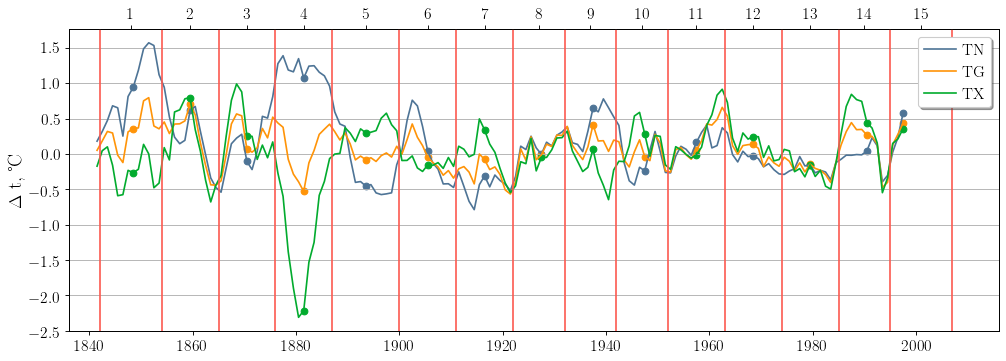

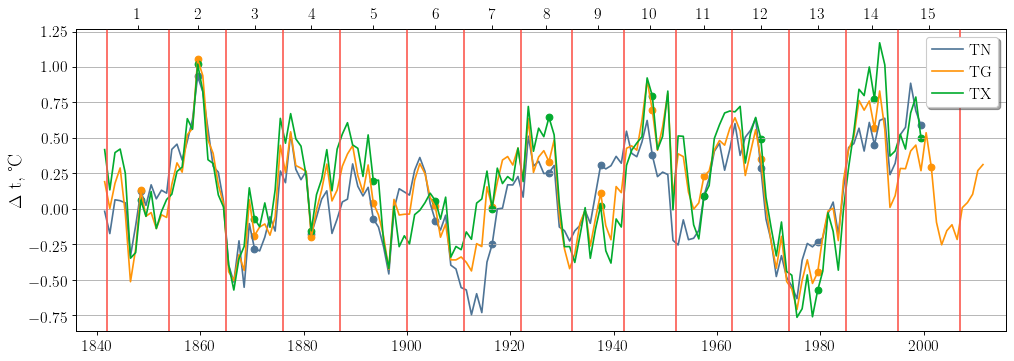

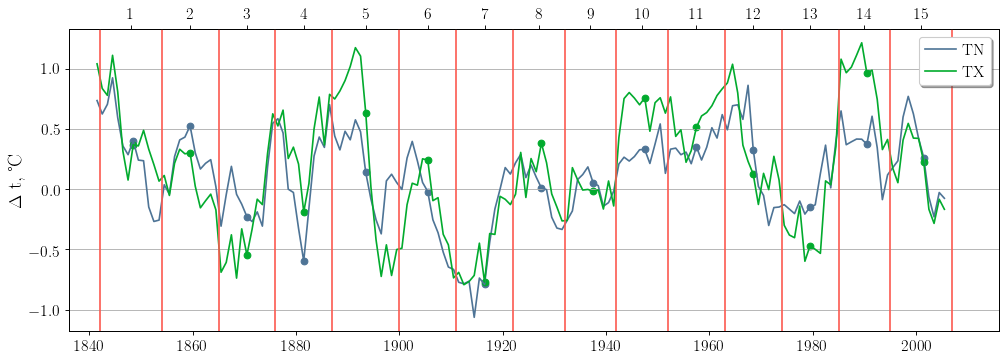

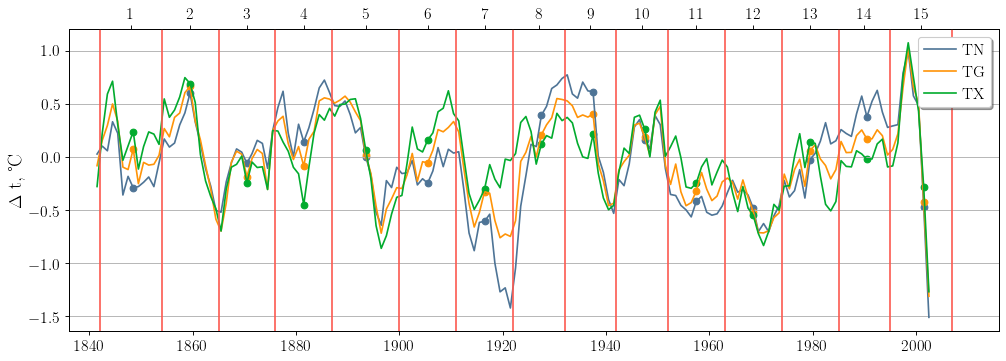

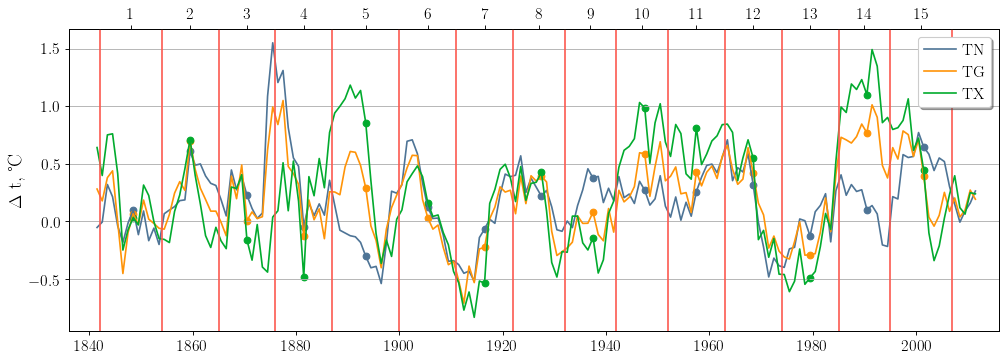

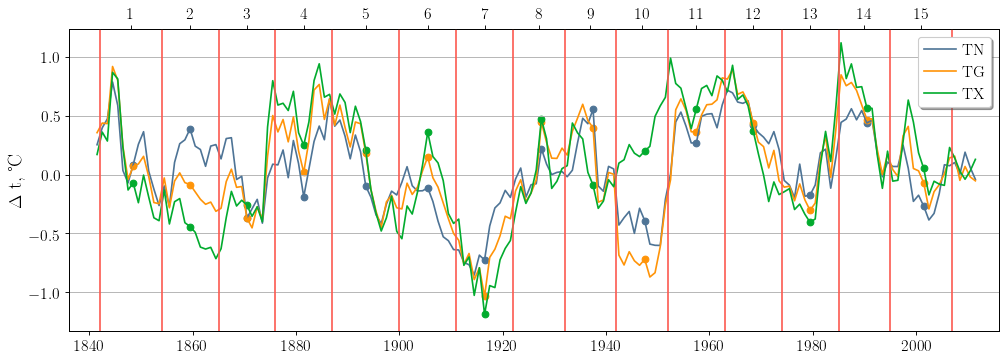

In [49]:
cities_dif = dict()
for city in cities: 
    cities_dif[city] = PrintMeanDiffAndSolarCycles(PERIOD, city, np.nanmedian)

In [50]:
median_temp_df = pd.DataFrame.from_dict(data=cities_dif, orient="index")
median_temp_df

,min,avg,max
Bologna,0.1568,0.0744,-0.0144
Prague,0.0925,0.1249,0.1758
Uccle,0.1186,NaN,0.1840
Milan,-0.0344,-0.0161,0.0069
Jena,0.1795,0.1999,0.2539
Oxford,0.0454,0.0480,0.0826


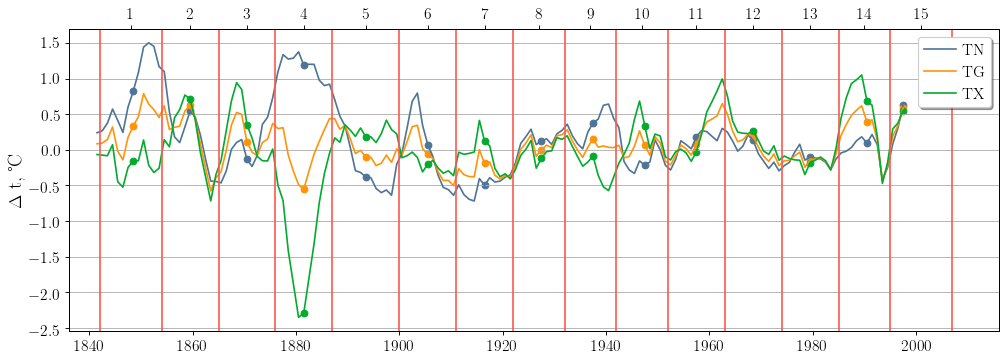

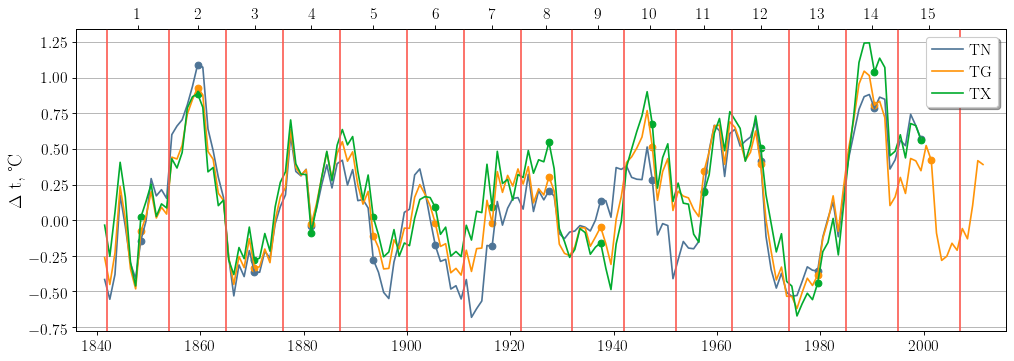

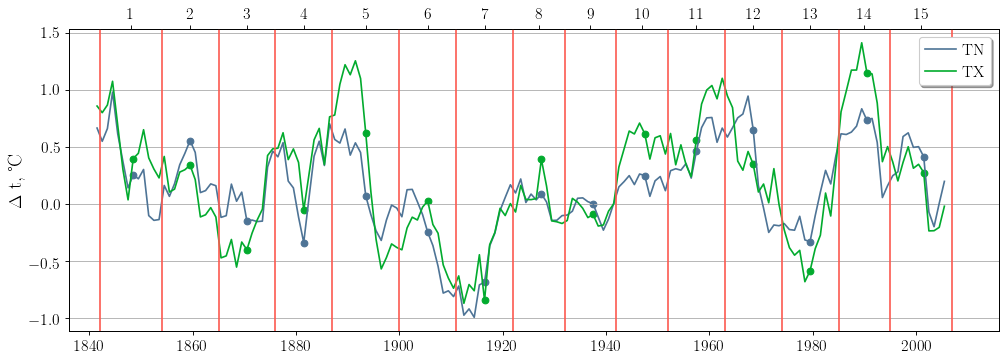

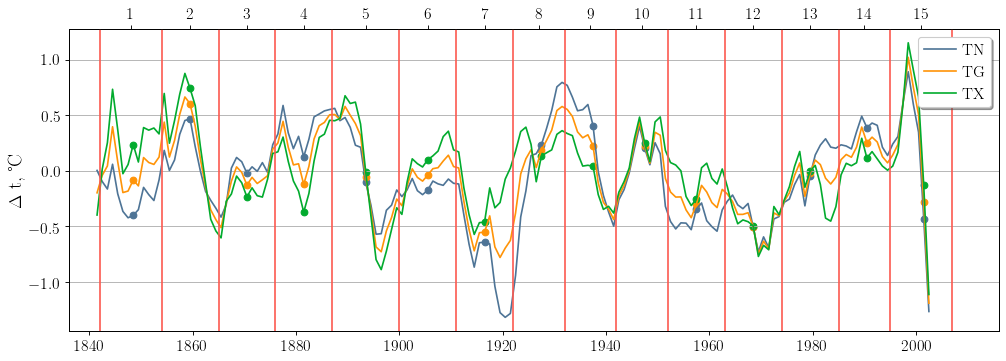

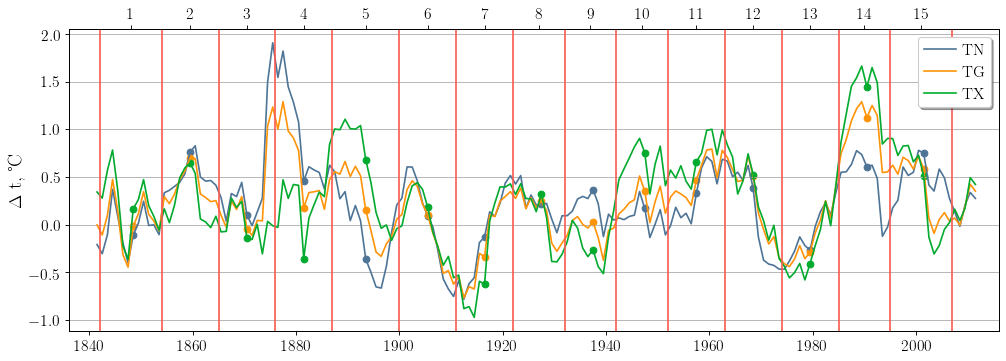

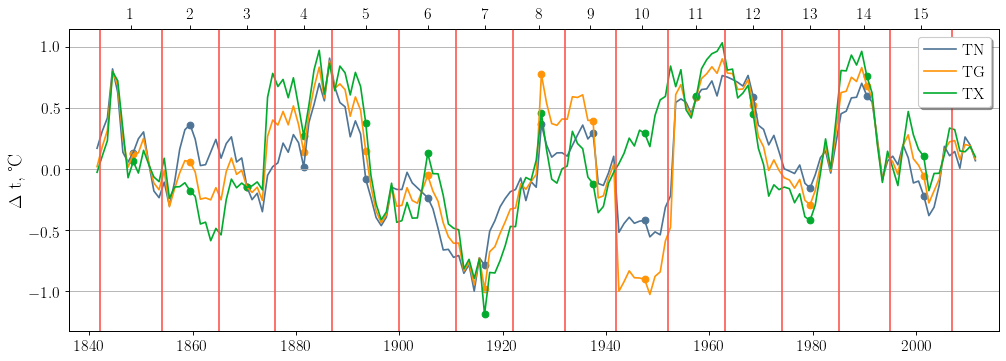

In [51]:
cities_dif = dict()
for city in cities: 
    cities_dif[city] = PrintMeanDiffAndSolarCycles(PERIOD, city, np.nanmean)

In [52]:
mean_temp_df = pd.DataFrame.from_dict(data=cities_dif, orient="index")
mean_temp_df

,min,avg,max
Bologna,0.1424,0.0620,-0.0183
Prague,0.1033,0.1318,0.1932
Uccle,0.1382,NaN,0.1989
Milan,-0.0556,-0.0202,0.0151
Jena,0.2224,0.2317,0.2636
Oxford,0.0643,0.0584,0.1151


Let's compare gained results with average difference between temperatures in randomly chosen periods of high and low levels of solar activity. 

In [ ]:
def NewMeanRandomDiff(data, period_years, mean_func):
    temp_diff, date_diff = [], []
    t = [data[i]["temp"] for i in range(len(data))]
    mean_temp = np.mean(t) / 10
    delta = period_years * DAYS_NUMBER
    
    start_year = 1836
    finish_year = start_year + period_years
    end_date = data[-1]["date"]
    end_year = int(end_date[:4])
    
    new_years = []
    for i in range(1, len(years_of_minimum)-1):
        cur, nex = years_of_minimum[i], years_of_minimum[i+1]
        window_years = np.arange(cur, nex)
        copy_years = window_years.copy()
        np.random.shuffle(window_years)
        for year in copy_years:
            new_years.append((year, window_years[year - cur]))
    new_window_years = dict(new_years)

    end_date = data[-1]["date"]
    end_year = int(end_date[:4])
    
    new_start_index, start_index = 0, 0        
    while finish_year <= min(years_of_minimum[-1], end_year):
        start_date, finish_date = datetime.date(start_year, 1, 1), datetime.date(finish_year, 1, 1)
        mid_date = start_date + datetime.timedelta(days=delta // 2)
        cur_measurements_low = [[] for day in range(DAYS_NUMBER)]
        cur_measurements_high = [[] for day in range(DAYS_NUMBER)]
        
        cur_activity = SortedSet()
        cur_date = start_date
        while cur_date < finish_date: # здесь делим на высокую и низкую активность
            if (cur_date.month, cur_date.day) != (2, 29):
                cur_shift_date = datetime.date(new_window_years[cur_date.year], cur_date.month, cur_date.day)
                if cur_shift_date in day_spots:
                    cur_activity.add((day_spots[cur_shift_date], cur_shift_date))
            cur_date += datetime.timedelta(days=1) # = завтра
        
        for i in range(start_index, len(data)):
            date, temperature = data[i]["date"], data[i]["temp"] / 10 - mean_temp
            year, month, day = int(date[:4]), int(date[4:6]), int(date[6:])
            cur_date = datetime.date(year, month, day)
            
            if cur_date < start_date:
                new_start_index = i
                continue
            elif cur_date >= finish_date:
                break
            
            cur_shift_date = datetime.date(new_window_years[year], month, day)
            day = GetDayNumber(cur_shift_date)
            samples = [day - 2, day - 1, day, (day + 1) % DAYS_NUMBER, (day + 2) % DAYS_NUMBER]
            if cur_shift_date in day_spots and cur_activity.__contains__((day_spots[cur_shift_date], cur_shift_date)):
                if cur_activity.index((day_spots[cur_shift_date], cur_shift_date)) <= len(cur_activity) / 2:
                    for j in samples:
                        cur_measurements_low[j].append(temperature)
                elif cur_activity.index((day_spots[cur_shift_date], cur_shift_date)) > len(cur_activity) / 2:
                    for j in samples:
                        cur_measurements_high[j].append(temperature)
        
        start_index = new_start_index + 1
        if (mid_date.month, mid_date.day) != (2, 29):
            low_len = np.mean([len(cur_measurements_low[j]) for j in range(len(cur_measurements_low))])
            high_len = np.mean([len(cur_measurements_high[j]) for j in range(len(cur_measurements_high))])
            diff = GetMean(cur_measurements_high, cur_measurements_low, np.nanmean)
            temp_diff.append(mean_func(diff))
            date_diff.append(mid_date)

        start_year += 1
        finish_year += 1
    return np.array(temp_diff)

def NewRandomTest(data, mean_func):
    test_diff = [[] for i in range(TEST_NUMBER)]
    for i in range(TEST_NUMBER):
        cur_random_diff = NewMeanRandomDiff(data, PERIOD, mean_func)
        test_diff[i] = cur_random_diff
    return np.array(test_diff)

In [ ]:
def GetRandomTestResults(city, mean_func):
    for case in cases[city]:
        data = GetTemperatureFileText(city, case)
        mean_random_diff = NewRandomTest(data, mean_func)

        file_name = "random/{}_{}_{}.txt".format(
            suffix_letter[case], city, func_name[mean_func])
        cur_file = open(file_name, "w")
        for i in range(len(mean_random_diff)):
            print(" ".join(map(str, mean_random_diff[i])), file=cur_file)

In [ ]:
for city in cities:
    if city != "Prague":
        GetRandomTestResults(city, np.nanmean)
        print(city)

In [192]:
for city in cities:
    GetRandomTestResults(city, np.nanmedian)
    print(city)

Bologna
Prague
Uccle
Milan
Jena
Oxford


In [36]:
def PrintRandomTestResults(city, mean_func, test_dif):
    for case in cases[city]:
        file_name = "random/{}_{}_{}.txt".format(
            suffix_letter[case], city, func_name[mean_func])
        mean_random_diff = np.loadtxt(file_name, dtype=float)
        mean_rows_diff = np.nanmean(mean_random_diff, axis=1) # среднее вдоль строк
        mean_cols_diff = np.nanmean(mean_random_diff, axis=0) # среднее вдоль столбцов
                
        years, day_diff = MeanShortDiff(city, case, PERIOD, mean_func)
        index_min = np.where(day_diff == day_diff[1:-1].min())[0][0]
        index_max = np.where(day_diff == day_diff[1:-1].max())[0][0]

        real_mean_diff = np.nanmean(day_diff)
        random_mean_diff = mean_rows_diff.mean()
        sorted_mean_diff = np.sort(mean_rows_diff)
        min_greater = np.sum(mean_rows_diff <= real_mean_diff)
        
        test_for_min = mean_random_diff[
            FindNearestValueIndex(mean_random_diff[:,index_min], np.median(mean_random_diff[:,index_min]))]
        test_for_max = mean_random_diff[
            FindNearestValueIndex(mean_random_diff[:,index_max], np.median(mean_random_diff[:,index_max]))]
                
        test_dif["{}_{}".format(city, case)] = {
                f"random_{func_name[mean_func]}": np.round(random_mean_diff, decimals=4), # по строкам
                f"real_{func_name[mean_func]}": np.round(real_mean_diff, decimals=4),
                "min %": min_greater}
        print(city, case, test_dif["{}_{}".format(city, case)])
        pic_name = GetPicName(city, case, "random_{}".format(func_name[mean_func]))
        fig = plt.figure(dpi=DPI, figsize=(SIZE_X, SIZE_Y))
        plt.grid(True)
#        plt.title("Средние разницы {} температур в {} для случайного деления на периоды активности"
#                  .format(full_case_r[case], cities_r[city]))
        assert(len(years) == len(day_diff))
        plt.plot(years, day_diff, label=f"настоящая разница {suffix_letter[case]}", color="xkcd:marine")
        plt.plot(years, test_for_min, label="медианный тест для минимума", color="xkcd:bordeaux")
        plt.plot(years, test_for_max, label="медианный тест для максимума", color="xkcd:orange red")
        plt.plot(years, mean_cols_diff, label="средняя разница за тесты", color="xkcd:bright lavender")
        plt.legend(handletextpad=0.4, shadow=0.1, fontsize=14, loc="upper right")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.ylim((-1, 1.75))
        plt.show()
        fig.savefig(pic_name, bbox_inches='tight', pad_inches=0.05)

Bologna min {'random_avg': 0.0062, 'real_avg': 0.1424, 'min %': 96}


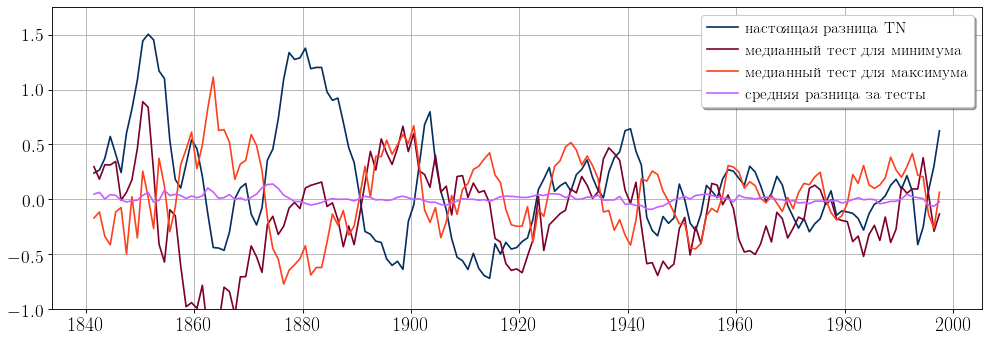

Bologna avg {'random_avg': 0.012, 'real_avg': 0.062, 'min %': 72}


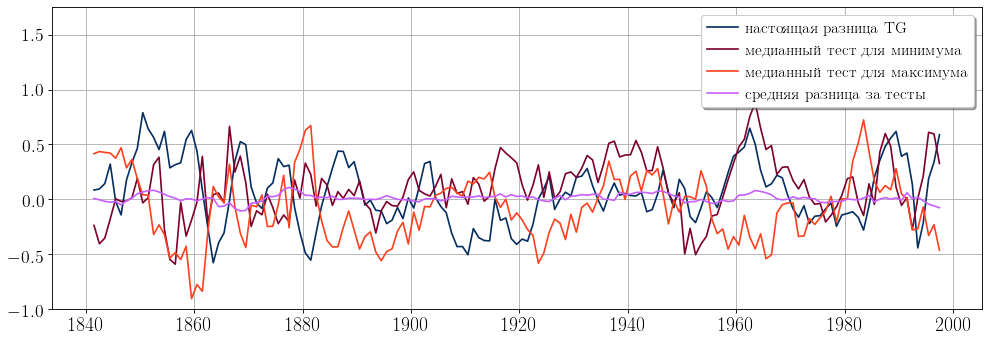

Bologna max {'random_avg': 0.0161, 'real_avg': -0.0183, 'min %': 34}


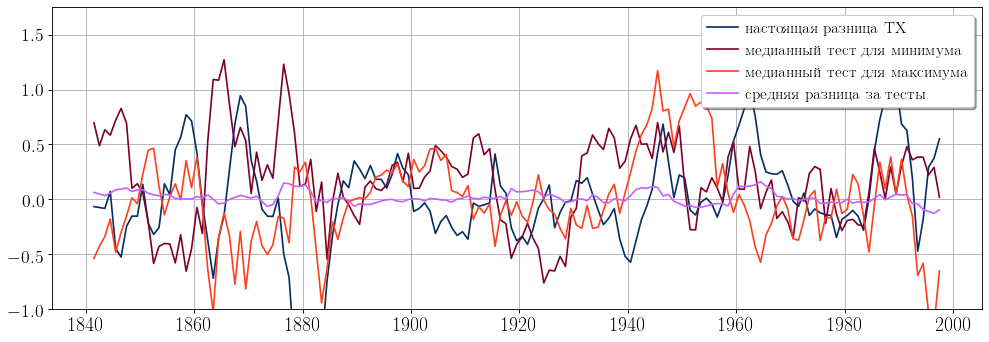

Prague min {'random_avg': -0.0028, 'real_avg': 0.1033, 'min %': 84}


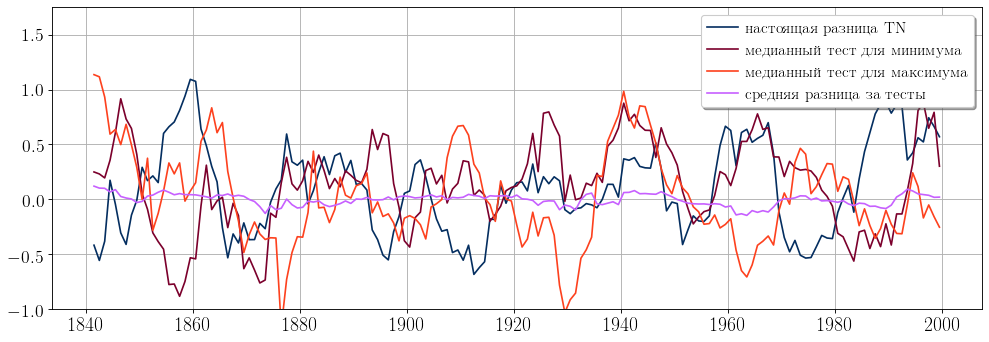

Prague avg {'random_avg': 0.0203, 'real_avg': 0.1456, 'min %': 87}


ValueError: x and y must have same first dimension, but have shapes (158,) and (171,)

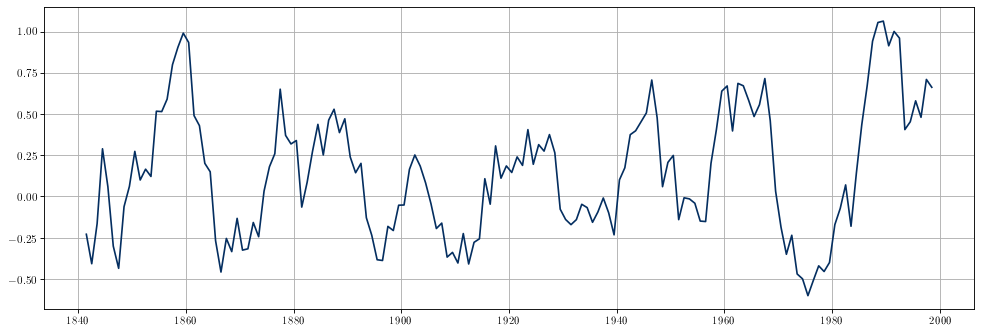

In [37]:
test_mean_dif = dict()
for city in cities:
    PrintRandomTestResults(city, np.nanmean, test_mean_dif)

In [ ]:
test_mean_df = pd.DataFrame.from_dict(data=test_mean_dif, orient="index")
test_mean_df

In [ ]:
test_median_dif = dict()
for city in cities:
    PrintRandomTestResults(city, np.nanmedian, test_median_dif)

In [ ]:
test_median_df = pd.DataFrame.from_dict(data=test_median_dif, orient="index")
test_median_df